In [11]:
import torch
import torch.nn as nn
import numpy as np
import sys
import os
import pprint
#from torchsummary import summary
from torchinfo import summary
import h5py
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset
import torch.autograd as autograd
from torch import optim
import pandas as pd
import scipy.io

In [12]:
import matlab.engine
eng = matlab.engine.start_matlab('MATLAB_R2021b')

In [13]:
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("using cuda:", torch.cuda.get_device_name(0))
    pass
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

using cuda: NVIDIA GeForce GTX 1660 Ti


device(type='cuda')

## Generator

In [14]:
class netG(nn.Module):
    def __init__(self, nc = 1, nz = 1, ngf = 64, gfs = 5, ngpu = 1):
        super(netG, self).__init__()
        self.ngpu = ngpu

        self.main = nn.Sequential(

                nn.ConvTranspose2d(     nz, ngf * 8, gfs, 2, gfs//2, bias=False), 
                nn.ReLU(True),
                nn.InstanceNorm2d(ngf * 8),

                nn.ConvTranspose2d(ngf * 8, ngf * 4, gfs, 2, gfs//2, bias=False),
                nn.ReLU(True),
                nn.InstanceNorm2d(ngf * 4),

                nn.ConvTranspose2d(ngf * 4, ngf * 2, gfs, 2, gfs//2, bias=False),
                nn.ReLU(True),
                nn.InstanceNorm2d(ngf * 2),

                nn.ConvTranspose2d(ngf * 2,     ngf, gfs, 2, gfs//2, bias=False),
                nn.ReLU(True),
                nn.InstanceNorm2d(ngf),
               
                nn.ConvTranspose2d(    ngf,      nc, 4, 2, 2, bias=False),
                nn.ReLU(True),
                
                ### Start dilations ###
                nn.ConvTranspose2d(     nc,ngf, gfs, 1, 6, output_padding=0,bias=False,dilation=3), 
                nn.ReLU(True),
                nn.InstanceNorm2d(ngf),
               
                nn.ConvTranspose2d(    ngf,  nc, gfs, 1, 10, output_padding=0, bias=False,dilation=5),
                
                nn.Tanh()
                
            )

    def forward(self, input):
        input = input.view(input.size(0), -1, 5, 5) # (*, 100, 1, 1)
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input,
                                               range(self.ngpu))
        else:
            output = self.main(input)
        return output

## import the trained generator

In [15]:
G = netG().cuda()

In [16]:
G.load_state_dict(torch.load('netG_epoch_27.pth'))

<All keys matched successfully>

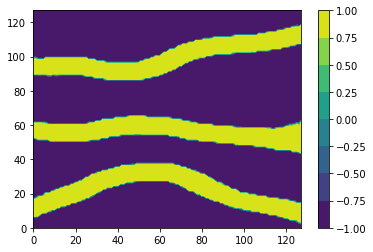

In [17]:
noise = torch.rand(1, 25)*2-1
z =noise.cuda()
fake = G(z)
plt.contourf(fake[0][0].detach().cpu().numpy())
plt.colorbar()

## Getting the N_{e} groups of z and G(z)

In [31]:
Ne = 100
z_dim = 25
ngx = 128
ngy = 128

In [20]:
%%time
z_Ne = np.zeros((z_dim, Ne))
cond_Ne = np.zeros(((ngx * ngy),Ne))
for i in range(Ne):
    z = torch.rand(1,z_dim)*2-1
    output = G.forward(z.cuda())
    b1=torch.full(output[0][0].shape, 6).cuda()
    b2=torch.full(output[0][0].shape, 2).cuda()
    aa = torch.where(output[0] > 0, b1, b2)
    a = aa.squeeze().cpu().detach().numpy()
    a = a.reshape(128*128,)
    z_Ne[:,i] = z.cpu().numpy()
    cond_Ne[:,i] = a
#scipy.io.savemat('z_Ne.mat', {"z_Ne":z_Ne}) 
scipy.io.savemat('cond_100.mat', {"cond_Ne":cond_Ne})

Wall time: 521 ms


## 获取随机生成结果的tensor

In [32]:
%%time
z_Ne = np.zeros((z_dim, Ne))
list_a=[]
list_b=[]
for i in range(Ne):
    z = torch.rand(1,z_dim)*2-1
    output = G.forward(z.cuda())
    a = output.squeeze().cpu().detach().numpy()
    list1=[]
    for i in range(len(a)):
        for j in a[i]:
            list1.append(j)
    a=b=0
    for ii in list1:
        if ii<0:
            a+=1
        else:
            b+=1
    list_a.append(a/16384*100)
    list_b.append(b/16384*100)


Wall time: 4.05 s


In [34]:
df = pd.DataFrame(list_b,columns=['channel'])
df["matrix"]=list_a
df.to_excel("generate_faces.xlsx", index=False)

## import the surrogate model

In [8]:
import argparse
import torch.nn.functional as F
from collections import OrderedDict

In [9]:
class _DenseLayer(nn.Sequential):

    def __init__(self, in_features, growth_rate, drop_rate=0, bn_size=4, bottleneck=False):
        super(_DenseLayer, self).__init__()
        
        if bottleneck and in_features > bn_size * growth_rate:
            self.add_module('norm1', nn.BatchNorm2d(in_features))
            self.add_module('relu1', nn.ReLU(inplace=True))
            
            self.add_module('conv1', nn.Conv2d(in_features, bn_size *
                            growth_rate, kernel_size=1, stride=1, bias=False))
            
            self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate))
            self.add_module('relu2', nn.ReLU(inplace=True))
            
            self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                            kernel_size=3, stride=1, padding=1, bias=False))
            
        else:
            self.add_module('norm1', nn.BatchNorm2d(in_features))
            self.add_module('relu1', nn.ReLU(inplace=True))
            
            self.add_module('conv1', nn.Conv2d(in_features, growth_rate, kernel_size=3, stride=1, padding=1, bias=False))
        self.drop_rate = drop_rate

    def forward(self, x):
        y = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            y = F.dropout2d(y, p=self.drop_rate, training=self.training) 
        z = torch.cat([x, y], 1)
        return z
class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, in_features, growth_rate, drop_rate, bn_size=4, bottleneck=False):
        super(_DenseBlock, self).__init__()
        
        for i in range(num_layers):
            layer = _DenseLayer(in_features + i * growth_rate, growth_rate, drop_rate=drop_rate, bn_size=bn_size, bottleneck=bottleneck)
            self.add_module('denselayer%d' % (i + 1), layer)
class _Transition(nn.Sequential):
    
    def __init__(self, in_features, out_features, encoding=True, drop_rate=0., last=False, out_channels=3, outsize_even=True):
        super(_Transition, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(in_features))
        self.add_module('relu1', nn.ReLU(inplace=True))
        
        # encoding
        if encoding:
            # reduce feature maps; half image size (input feature size is even)
            # bottleneck impl, save memory, add nonlinearity
            self.add_module('conv1', nn.Conv2d(in_features, out_features, kernel_size=1, stride=1, padding=0, bias=False))
            
            if drop_rate > 0:
                self.add_module('dropout1', nn.Dropout2d(p=drop_rate))
            self.add_module('norm2', nn.BatchNorm2d(out_features))
            self.add_module('relu2', nn.ReLU(inplace=True))
            self.add_module('conv2', nn.Conv2d(out_features, out_features,
                                              kernel_size=3, stride=2,
                                              padding=1, bias=False))

            if drop_rate > 0:
                self.add_module('dropout2', nn.Dropout2d(p=drop_rate))
        else:
            # decoder
            if last:
                ks = 6 if outsize_even else 3
                out_convt = nn.ConvTranspose2d(out_features, out_channels,kernel_size=ks, stride=2,padding=1, bias=False)
            else:
                out_convt = nn.ConvTranspose2d(out_features, out_features,kernel_size=3, stride=2,padding=1, output_padding=0, bias=False)

            # bottleneck impl, save memory, add nonlinearity
            self.add_module('conv1', nn.Conv2d(in_features, out_features,kernel_size=1, stride=1,padding=0, bias=False))

            if drop_rate > 0:
                self.add_module('dropout1', nn.Dropout2d(p=drop_rate))

            self.add_module('norm2', nn.BatchNorm2d(out_features))
            self.add_module('relu2', nn.ReLU(inplace=True))
            self.add_module('convT2', out_convt)
            if drop_rate > 0:
                self.add_module('dropout2', nn.Dropout2d(p=drop_rate))

In [12]:
class DenseED(nn.Module):
    def __init__(self, in_channels, out_channels, blocks, growth_rate=16,
                 num_init_features=64, bn_size=4, drop_rate=0, outsize_even=True,
                 bottleneck=False):

        super(DenseED, self).__init__()

        if len(blocks) > 1 and len(blocks) % 2 == 0:
            ValueError('length of blocks must be an odd number, but got {}'.format(len(blocks)))
            
        enc_block_layers = blocks[: len(blocks) // 2]
        dec_block_layers = blocks[len(blocks) // 2:]
        self.features = nn.Sequential()
        self.features.add_module('in_conv',nn.Conv2d(in_channels, num_init_features,kernel_size=7, stride=2, padding=3, bias=False))
        #self.features.add_module('in_conv',nn.Conv2d(in_channels, num_init_features,kernel_size=6, stride=2, padding=2, bias=False))

        num_features = num_init_features
        for i, num_layers in enumerate(enc_block_layers):
            block = _DenseBlock(num_layers=num_layers,
                                in_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate,
                                drop_rate=drop_rate, bottleneck=bottleneck)
            self.features.add_module('encblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate

            trans = _Transition(in_features=num_features,
                                out_features=num_features // 2,
                                encoding=True, drop_rate=drop_rate)
            self.features.add_module('down%d' % (i + 1), trans)
            num_features = num_features // 2

        for i, num_layers in enumerate(dec_block_layers):
            block = _DenseBlock(num_layers=num_layers,
                                in_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate,
                                drop_rate=drop_rate, bottleneck=bottleneck)
            self.features.add_module('decblock%d' % (i + 1), block)
            num_features += num_layers * growth_rate

            last_layer = True if i == len(dec_block_layers) - 1 else False

            trans = _Transition(in_features=num_features,
                                out_features=num_features // 2,
                                encoding=False, drop_rate=drop_rate,
                                last=last_layer, out_channels=out_channels,
                                outsize_even=outsize_even)
            self.features.add_module('up%d' % (i + 1), trans)
            num_features = num_features // 2

    def forward(self, x):
        y = self.features(x)
        y[:, 0] = F.softplus(y[:, 0].clone(), beta=1)

        return y

    def _num_parameters_convlayers(self):
        n_params, n_conv_layers = 0, 0
        for name, param in self.named_parameters():
            if 'conv' in name:
                n_conv_layers += 1
            n_params += param.numel()
        return n_params, n_conv_layers

    def _count_parameters(self):
        n_params = 0
        for name, param in self.named_parameters():
            print(name)
            print(param.size())
            print(param.numel())
            n_params += param.numel()
            print('num of parameters so far: {}'.format(n_params))

    def reset_parameters(self, verbose=False):
        for module in self.modules():
            # pass self, otherwise infinite loop
            if isinstance(module, self.__class__):
                continue
            if 'reset_parameters' in dir(module):
                if callable(module.reset_parameters):
                    module.reset_parameters()
                    if verbose:
                        print("Reset parameters in {}".format(module))

In [13]:
parser = argparse.ArgumentParser(description='Dnense Encoder-Decoder Convolutional Network')
parser.add_argument('--exp-name', type=str, default='AR-Net', help='experiment name')
parser.add_argument('--blocks', type=list, default=(5, 10, 5),
                    help='list of number of layers in each block in decoding net')  
parser.add_argument('--growth-rate', type=int, default=40, help='output of each conv')  
parser.add_argument('--drop-rate', type=float, default=0, help='dropout rate')
parser.add_argument('--bn-size', type=int, default=8, help='bottleneck size: bn_size * growth_rate')
parser.add_argument('--bottleneck', action='store_true', default=False, help='enable bottleneck in the dense blocks')
parser.add_argument('--init-features', type=int, default=48,
                    help='# initial features after the first conv layer') 

parser.add_argument('--data-dir', type=str, default="./", help='data directory')


parser.add_argument('--n-train', type=int, default=2000, help="number of training data")
parser.add_argument('--n-test', type=int, default=500, help="number of test data")

parser.add_argument('--w-c', type=float, default=8.0, help='weight value in the weighted loss')
parser.add_argument('--w-c2', type=float, default=4.0, help='weight value in the weighted loss')
parser.add_argument('--n-epochs', type=int, default=200, help='number of epochs to train (default: 200)')
parser.add_argument('--lr', type=float, default=0.0002, help='learnign rate')

parser.add_argument('--weight-decay', type=float, default=5e-5, help="weight decay")
parser.add_argument('--batch-size', type=int, default=16, help='input batch size for training (default: 100)')
parser.add_argument('--test-batch-size', type=int, default=32, help='input batch size for testing (default: 100)')
parser.add_argument('--log-interval', type=int, default=1,
                    help='how many epochs to wait before logging training status')
parser.add_argument('--plot-interval', type=int, default=2,
                    help='how many epochs to wait before plotting training status')
args = parser.parse_args(args=[])

In [14]:
model = DenseED(3, 2, blocks=args.blocks, growth_rate=args.growth_rate,
                        drop_rate=args.drop_rate, bn_size=args.bn_size,
                        num_init_features=args.init_features, bottleneck=args.bottleneck).to(device)

In [15]:
model_dir = "./"
model.load_state_dict(torch.load(model_dir + '/model_epoch{}.pth'.format(198)))
print('Loaded model')

Loaded model


In [16]:
def get_simv(y_pred):
    scipy.io.savemat('y_pred.mat', dict(y_pred=y_pred))
    eng.interp_matlab(nargout=0)
    y_sim = np.loadtxt("y_sim.dat")
    return y_sim

In [27]:
def run_surrogate(X, Nt, model):

    model.eval()
    
    # cond
    z_a = X[0:25]
    z = torch.tensor(z_a)
    z = z.unsqueeze(0)
    z = z.float()
    output = G.forward(z.cuda())
    b1=torch.full(output[0][0].shape, 6).cuda()
    b2=torch.full(output[0][0].shape, 2).cuda()
    aa = torch.where(output[0] > 0, b1, b2)
    cond = aa.squeeze().cpu().detach().numpy()
    
    
    #
    ss = X[25:]
    Sx_id = 15
    source = np.full((Nt,128,128), 0.0)
    for j in range(Nt):
        for ii in range(22,103):
            Sy_id = ii
            source[j, Sy_id, Sx_id] = ss[j]

    x = np.full((1,3,128,128), 0.0)   
    y = np.full( (Nt,2,128,128), 0.0) 
    y_i_1 = np.full((128,128), 0.0)   
    for i in range(Nt):
        x[0,0,:,:] = cond           
        x[0,1,:,:] = source[i]      
        x[0,2,:,:] = y_i_1          
        x_tensor = (torch.FloatTensor(x)).to(device)
        with torch.no_grad():
            y_hat = model(x_tensor)
        y_hat = y_hat.data.cpu().numpy()
        y[i] = y_hat
        y_i_1 = y_hat[0,0,:,:]      
    
    y_pred = np.full( (Nt + 1,128,128), 0.0)
    y_pred[:Nt] = y[:,0]   
    y_pred[Nt]  = y[0,1]  

    y_pre_obs = get_simv(y_pred)
    
    return y_pre_obs

## no surrogate model

In [ ]:
##GMS
x_para = scipy.io.loadmat('x1.mat')
xf = x_para['x1']

obs_model = scipy.io.loadmat('y1.mat')
yf = obs_model['conc_head_Ne']


scipy.io.savemat('xf.mat', {"xf": xf})
scipy.io.savemat('yf.mat', {"yf": yf})
xall = xf
yall = yf


## using surrogate model

In [ ]:
x1 = scipy.io.loadmat('x1.mat')
x1 = x1['x1']   
Nobs = 15*8+15
Nt = 8
y1 = np.zeros((Nobs,x1.shape[1]))
for i in range(x1.shape[1]):  # (x1, y1) are initial samples
    y1[:,i] = run_surrogate(x1[:,i], Nt, model)
scipy.io.savemat('y1.mat', dict(y1=y1))
xf = x1
yf = y1
scipy.io.savemat('xf.mat', dict(xf=xf))  # Initial ensemble
scipy.io.savemat('yf.mat', dict(yf=yf))
xall = xf
yall = yf

## Setting N_{t}

In [ ]:
%%time
Nt = 8
Nobs = 15*8+15

N_iter = 5
for i in range(N_iter):
    eng.ilues1(nargout=0)
    xa = scipy.io.loadmat('xa.mat')
    xa = xa['xa']
    print('iter=',i+1)
    
    z_a = xa[0:25,:]
    ss_a = xa[25:,:]
    scipy.io.savemat('z_a.mat', {"z_a": z_a})
    scipy.io.savemat('ss_a.mat', {"ss_a": ss_a})
    
    ya = np.zeros((Nobs, xa.shape[1]))
    for j in range(xa.shape[1]):
        ya[:,j] = run_surrogate(xa[:,j], Nt, model)
    scipy.io.savemat('ya.mat', dict(ya=ya))
    
    
    eng.update_samples(nargout=0) 
    xa = scipy.io.loadmat('xa.mat') 
    ya = scipy.io.loadmat('ya.mat')
    xa = xa['xa']
    ya = ya['ya']
    
    xall = np.concatenate((xall,xa),axis=1)
    yall = np.concatenate((yall,ya),axis=1)
scipy.io.savemat('results.mat', {"xall": xall,"yall":yall})  # save results